# Установка зависимостей

In [1]:
!pip install librosa numpy tqdm

In [2]:
# Загрузка натренированных моделей
!gdown https://drive.google.com/uc?id=1PPrH-wJ_Bk14I91ddBxfkaZ8FOyUBuJx

Downloading...
From: https://drive.google.com/uc?id=1PPrH-wJ_Bk14I91ddBxfkaZ8FOyUBuJx
To: /content/models.zip
100% 5.75M/5.75M [00:00<00:00, 19.3MB/s]


In [3]:
# Распаковка архива
!unzip models

Archive:  models.zip
   creating: models/
  inflating: models/eq_linear_ready.h5  
  inflating: models/eq_nonlinear_ready.h5  
  inflating: models/eq_weakly_nonlinear_ready.h5  
  inflating: models/noise_cancel_conv.h5  
  inflating: models/noise_cancel_lstm.h5  


In [4]:
# Загрузка noise_utils
!pip install git+https://github.com/vladimirch-afk/noise_utils.git

  Cloning https://github.com/vladimirch-afk/noise_utils.git to /tmp/pip-req-build-r1kr9doe
  Running command git clone --filter=blob:none --quiet https://github.com/vladimirch-afk/noise_utils.git /tmp/pip-req-build-r1kr9doe
  Resolved https://github.com/vladimirch-afk/noise_utils.git to commit 18b79cc139a205c7785071e95814802faf75c43c
  Preparing metadata (setup.py) ... done
  Created wheel for noise-utils: filename=noise_utils-0.0.10-py3-none-any.whl size=5142 sha256=6fa92222e820d42f5a8d7fce1d2133783b5c0fa408965f6123ebf9ef968a9a7a
  Stored in directory: /tmp/pip-ephem-wheel-cache-a2vugl6c/wheels/aa/99/4b/15da170997d26161b173dbfe80a7c92273af44a9392157d9a4
Successfully built noise-utils


In [5]:
import keras
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import soundfile as sf
import tensorflow as tf
from tqdm import tqdm
from tqdm.keras import TqdmCallback
# Собственная библиотека
from noise_utils import Noisemaker, SignalGenerator, DataPreparator
from tensorflow.keras import layers, models

# Эквализация сигнала

Эквализация сигнала - это процесс избавления сигнала от искажений, часто возникающих в процессе передачи. Существует множество агоритмов по эквализации сигнала, далее будут рассмотрены возможные нейросетевые алгоритмы.

# Эквалайзер для линейного сигнала

Линейный сигнал - это тип сигнала, который изменяется линейно с течением времени. Математически, линейный сигнал может быть представлен как функция $y=f(t)$, которая зависит линейно от времени или от какой-либо другой переменной.

Подготовим данные. `DataPreparator().generate_linear_dataset()` генерирует случайные линейные сигналы по формуле $y=ax+b$, где $a$, $b$ - случайные коэффициенты.

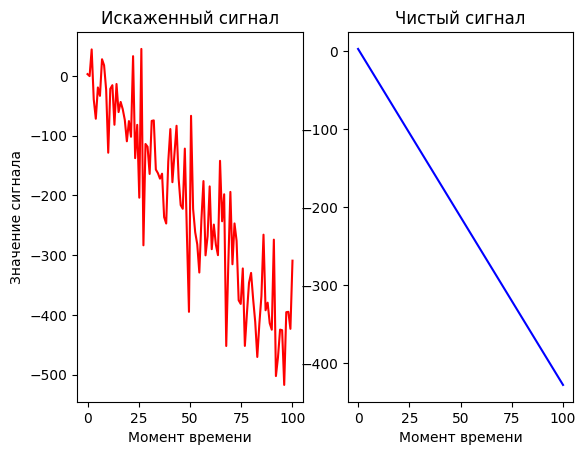

In [6]:
# Генерация обучающего набора данных
train_x, train_y = DataPreparator().generate_linear_dataset(200, 100, Noisemaker().add_perlin_noise)
# Генерация валидационного набора данных
val_x, val_y = DataPreparator().generate_linear_dataset(50, 100, Noisemaker().add_perlin_noise)
# Генерация тестового набора данных
test_x, test_y = DataPreparator().generate_linear_dataset(100, 100, Noisemaker().add_perlin_noise)

# Индекс для вывода случайного сигнала с зашумлением и без
index = 45

# Создание графика
fig, axs = plt.subplots(1, 2)

# Вывод зашумленного сигнала на первом графике
axs[0].plot(np.linspace(0, train_x[index].shape[0], train_x[index].shape[0]), train_x[index].flatten(), color='r')
axs[0].set_title("Искаженный сигнал")
axs[0].set_xlabel("Момент времени")
axs[0].set_ylabel("Значение сигнала")

# Вывод чистого сигнала на втором графике
axs[1].plot(np.linspace(0, train_y[index].shape[0], train_y[index].shape[0]), train_y[index].flatten(), color='b')
axs[1].set_title("Чистый сигнал")
axs[1].set_xlabel("Момент времени")
plt.show()

# Изменение формы обучающего набора данных для подготовки к обучению модели
train_x = train_x.reshape(-1, 100, 1)
train_y = train_y.reshape(-1, 100, 1)

# Изменение формы валидационного набора данных для подготовки к обучению модели
val_x = val_x.reshape(-1, 100, 1)
val_y = val_y.reshape(-1, 100, 1)

# Изменение формы тестового набора данных для подготовки к обучению модели
test_x = test_x.reshape(-1, 100, 1)
test_y = test_y.reshape(-1, 100, 1)


Создание и обучение модели.

In [7]:
"""
Эквалайзер для линейного сигнала
"""

# Создание модели для шумоочистки сигнала
def create_noise_canceling_model(input_shape):
    model = models.Sequential([
        layers.Conv1D(filters=30, kernel_size=4, activation='linear', padding='same', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=60, kernel_size=4, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=120, kernel_size=4, activation='relu', padding='same'),
        layers.UpSampling1D(size=2),
        layers.Conv1D(filters=60, kernel_size=4, activation='relu', padding='same'),
        layers.UpSampling1D(size=2),
        layers.Conv1D(filters=1, kernel_size=4, activation='linear', padding='same'),
    ])
    return model

# Определение размера окна
window_size = 20

# Генерация обучающего набора данных
X, y = DataPreparator().generate_linear_dataset(200, 100, Noisemaker().add_perlin_noise)

# Определение формы входных данных для модели
input_shape = (100, 1)

# Создание модели
model = create_noise_canceling_model(input_shape)

# Компиляция модели и обучение модели
model.compile(optimizer="adam", loss='mse')
print(model.summary())
model.fit(train_x,
          train_y,
          epochs=100,
          batch_size=32,
          callbacks=[TqdmCallback(verbose=1)],
          validation_data=(val_x, val_y),
          verbose=0)

# Сохранение обученной модели
model.save("eq_linear.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 30)           150       
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 30)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 60)            7260      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 25, 60)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 120)           28920     
                                                                 
 up_sampling1d (UpSampling1  (None, 50, 120)           0

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Загружаем заранее натренированную модель, чтобы не ждать окончание обучения.

In [9]:
model = keras.saving.load_model("models/eq_linear_ready.h5")

Оцениваем модель.

In [8]:
results = model.evaluate(test_x, test_y, batch_size=32)
display(results)

4/4 [==============================] - 0s 7ms/step - loss: 76.2459


76.2458724975586

Рассмотрим пример работы модели на одном конкретном сигнале.

1/1 [==============================] - 0s 170ms/step


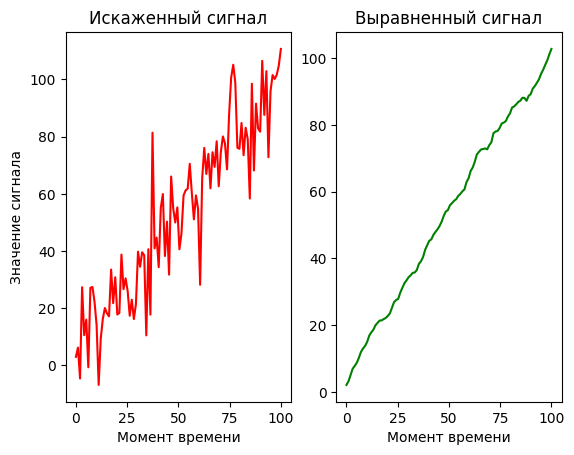

In [9]:
# Генерация линейного набора данных с шумом
x, y = DataPreparator().generate_linear_dataset(1, 100, Noisemaker().add_perlin_noise)
x = x.reshape(-1, 100)
y = y.flatten()

# Предсказание модели и выравнивание результатов
eq = model.predict(x).flatten()

# Создание графика
fig, axs = plt.subplots(1, 2)
lin_space = np.linspace(0, 100, 100)

# Построение графика зашумленного сигнала на первом графике
axs[0].plot(lin_space, x.flatten(), color='r')  # Красный - зашумленный
axs[0].set_title("Искаженный сигнал")
axs[0].set_xlabel("Момент времени")
axs[0].set_ylabel("Значение сигнала")

# Построение графика выравненного сигнала на втором графике
axs[1].plot(lin_space, eq.flatten(), color='g')  # Зеленый - очищенный
axs[1].set_title("Выравненный сигнал")
axs[1].set_xlabel("Момент времени")
plt.show()


# Эквалайзер для слабо нелинейного сигнала

Слабонелинейный сигнал - это тип сигнала, характеризующийся небольшой степенью нелинейности в своем поведении или динамике. Некоторые слабонелинейные сигналы математически можно представить в виде функций $cos()$, $sin()$.

Подготовка данных. `DataPreparator().generate_weakly_nonlinear_dataset()` генерирует случайные слабо линейные сигналы.

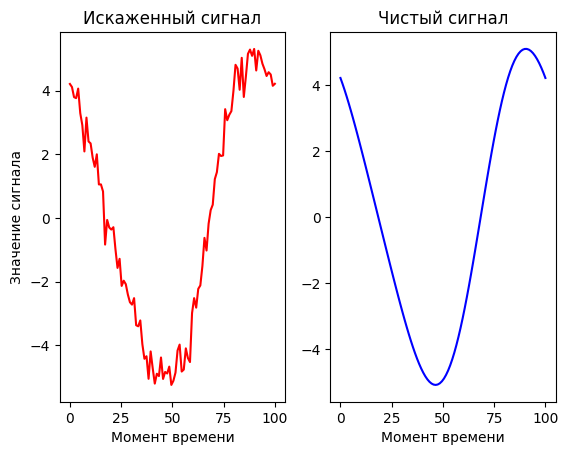

In [17]:
# Генерация обучающего набора данных: создание слабо нелинейного набора данных с шумом
train_x, train_y, _ = DataPreparator().generate_weakly_nonlinear_dataset(200, 100, Noisemaker().add_perlin_noise)
# Генерация валидационного набора данных: создание слабо нелинейного набора данных с шумом
val_x, val_y, _ = DataPreparator().generate_weakly_nonlinear_dataset(50, 100, Noisemaker().add_perlin_noise)
# Генерация тестового набора данных: создание слабо нелинейного набора данных с шумом
test_x, test_y, _ = DataPreparator().generate_weakly_nonlinear_dataset(100, 100, Noisemaker().add_perlin_noise)

# Индекс для вывода случайного сигнала с зашумлением и без
index = 45

# Создание графика
fig, axs = plt.subplots(1, 2)

# Построение графика зашумленного сигнала на первом графике
# Красный цвет для зашумленного сигнала
axs[0].plot(np.linspace(0, train_x[index].shape[0], train_x[index].shape[0]), train_x[index].flatten(), color='r')
axs[0].set_title("Искаженный сигнал")
axs[0].set_xlabel("Момент времени")
axs[0].set_ylabel("Значение сигнала")

# Построение графика чистого сигнала на втором графике
# Синий цвет для чистого сигнала
axs[1].plot(np.linspace(0, train_y[index].shape[0], train_y[index].shape[0]), train_y[index].flatten(), color='b')
axs[1].set_title("Чистый сигнал")
axs[1].set_xlabel("Момент времени")
plt.show()

# Изменение формы обучающего набора данных для подготовки к обучению модели
train_x = train_x.reshape(-1, 100, 1)
train_y = train_y.reshape(-1, 100, 1)

# Изменение формы валидационного набора данных для подготовки к обучению модели
val_x = val_x.reshape(-1, 100, 1)
val_y = val_y.reshape(-1, 100, 1)

# Изменение формы тестового набора данных для подготовки к обучению модели
test_x = test_x.reshape(-1, 100, 1)
test_y = test_y.reshape(-1, 100, 1)


Создание и обучение модели.

In [18]:
"""
Эквалайзер для слабо нелинейного сигнала
"""

# Создание модели для шумоочистки сигнала
def create_noise_canceling_model(input_shape):
    model = models.Sequential([
        # LSTM слой с 64 блоками, возвращающий последовательности, и входной формой данных
        layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        # LSTM слой с 64 блоками, возвращающий последовательности, и входной формой данных
        layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        # Применение полносвязного слоя на каждом временном шаге
        layers.TimeDistributed(layers.Dense(64)),
        # LSTM слой с 64 блоками, возвращающий последовательности, и входной формой данных
        layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        # LSTM слой с 64 блоками, возвращающий последовательности, и входной формой данных
        layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        # Применение полносвязного слоя на каждом временном шаге
        layers.TimeDistributed(layers.Dense(1)),
    ])
    return model

# Создание модели
window_size = 100 # Определение размера окна
input_shape = (window_size, 1)
model = create_noise_canceling_model(input_shape)

# Компиляция и обучение модели
model.compile(optimizer="adam", loss='mse')
print(model.summary())
model.fit(train_x,
          train_y,
          epochs=100,
          batch_size=32,
          callbacks=[TqdmCallback(verbose=1)],
          validation_data=(val_x, val_y),
          verbose=0)

# Сохранение обученной модели
model.save("eq_weakly_nonlinear.h5")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           16896     
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           33024     
                                                                 
 time_distributed (TimeDist  (None, 100, 64)           4160      
 ributed)                                                        
                                                                 
 lstm_2 (LSTM)               (None, 100, 64)           33024     
                                                                 
 lstm_3 (LSTM)               (None, 100, 64)           33024     
                                                                 
 time_distributed_1 (TimeDi  (None, 100, 1)            65        
 stributed)                                           

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Загружаем заранее натренированную модель, чтобы не ждать окончание обучения.

In [19]:
model = keras.saving.load_model("models/eq_weakly_nonlinear_ready.h5")

Оцениваем модель.

In [20]:
results = model.evaluate(test_x, test_y, batch_size=32)
display(results)

4/4 [==============================] - 2s 53ms/step - loss: 0.0377


0.0377483069896698

Рассмотрим пример работы модели на одном конкретном сигнале.

1/1 [==============================] - 4s 4s/step


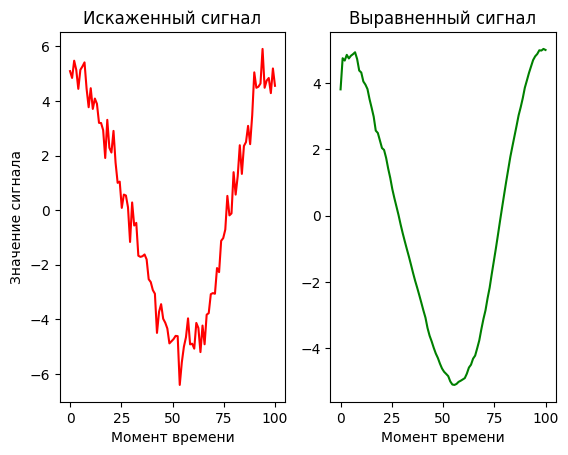

In [22]:
# Генерация набора данных: создание слабо нелинейного набора данных с шумом
x, y, _ = DataPreparator().generate_weakly_nonlinear_dataset(1, 100, Noisemaker().add_perlin_noise)

# Изменение формы входных данных
x = x.reshape(-1, 100)
y = y.flatten()

# Предсказание модели для выравнивания сигнала
eq = model.predict(x).flatten()

# Создание графика
lin_space = np.linspace(0, 100, 100)
fig, axs = plt.subplots(1, 2)

# Построение графика зашумленного сигнала на первом графике
axs[0].plot(lin_space, x.flatten(), color='r')  # Красный - зашумленный
axs[0].set_title("Искаженный сигнал")
axs[0].set_xlabel("Момент времени")
axs[0].set_ylabel("Значение сигнала")

# Построение графика выравненного сигнала на втором графике
axs[1].plot(lin_space, eq.flatten(), color='g')  # Зеленый - очищенный
axs[1].set_title("Выравненный сигнал")
axs[1].set_xlabel("Момент времени")
plt.show()


# Эквалайзер для нелинейного сигнала


Нелинейный сигнал - сигнал, который нельзя математически выразить линейно.

Подготовка данных. `DataPreparator().generate_weakly_nonlinear_dataset()` генерирует случайные слабо линейные сигналы.

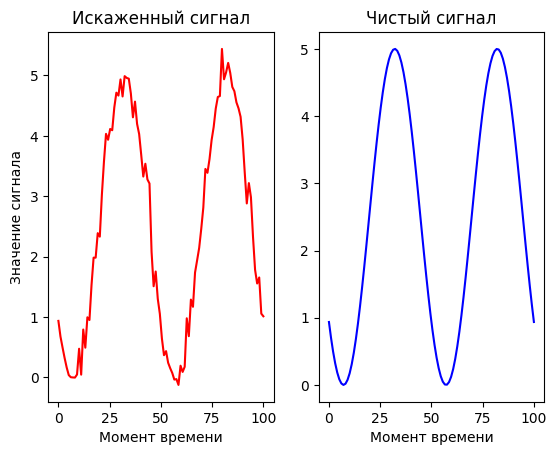

In [23]:
# Генерация обучающего набора данных: создание нелинейного набора данных с шумом
train_x, train_y = DataPreparator().generate_nonlinear_dataset(50, 100, Noisemaker().add_perlin_noise)
# Генерация валидационного набора данных: создание нелинейного набора данных с шумом
val_x, val_y = DataPreparator().generate_nonlinear_dataset(50, 100, Noisemaker().add_perlin_noise)
# Генерация тестового набора данных: создание нелинейного набора данных с шумом
test_x, test_y = DataPreparator().generate_nonlinear_dataset(50, 100, Noisemaker().add_perlin_noise)

# Индекс для вывода случайного сигнала с зашумлением и без
index = 45

# Создание графика
fig, axs = plt.subplots(1, 2)

# Построение графика зашумленного сигнала на первом графике
# Красный цвет для зашумленного сигнала
axs[0].plot(np.linspace(0, train_x[index].shape[0], train_x[index].shape[0]), train_x[index].flatten(), color='r')
axs[0].set_title("Искаженный сигнал")
axs[0].set_xlabel("Момент времени")
axs[0].set_ylabel("Значение сигнала")

# Синий цвет для чистого сигнала
axs[1].plot(np.linspace(0, train_y[index].shape[0], train_y[index].shape[0]), train_y[index].flatten(), color='b')
axs[1].set_title("Чистый сигнал")
axs[1].set_xlabel("Момент времени")
plt.show()

# Изменение формы обучающего набора данных
train_x = train_x.reshape(-1, 100, 1)
train_y = train_y.reshape(-1, 100, 1)

# Изменение формы валидационного набора данных
val_x = val_x.reshape(-1, 100, 1)
val_y = val_y.reshape(-1, 100, 1)

# Изменение формы тестового набора данных
test_x = test_x.reshape(-1, 100, 1)
test_y = test_y.reshape(-1, 100, 1)


Создание и обучение модели

In [24]:
"""
Эквалайзер для нелинейного сигнала
"""

# Создание LSTM-модели для шумоочистки сигнала
def create_noise_canceling_model(input_shape):
    model = models.Sequential([
        # LSTM слой с 100 блоками
        layers.LSTM(100, return_sequences=True, input_shape=input_shape),
        # LSTM слой с 50 блоками
        layers.LSTM(50, return_sequences=True, input_shape=input_shape),
        # LSTM слой с 50 блоками
        layers.LSTM(50, return_sequences=True, input_shape=input_shape),
        # Применение полносвязного слоя на каждом временном шаге последовательности
        layers.TimeDistributed(layers.Dense(1)),
    ])
    return model

# Определение формы входных данных для модели
window_size = 100 # Определение размера окна
input_shape = (window_size, 1)

# Создание модели
model = create_noise_canceling_model(input_shape)

# Компиляция и обучение модели
model.compile(optimizer="adam", loss='mse')
print(model.summary())
model.fit(train_x,
          train_y,
          epochs=100,
          batch_size=32,
          callbacks=[TqdmCallback(verbose=1)],
          validation_data=(val_x, val_y),
          verbose=0)

# Сохранение обученной модели
model.save("eq_nonlinear.h5")


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 100)          40800     
                                                                 
 lstm_5 (LSTM)               (None, 100, 50)           30200     
                                                                 
 lstm_6 (LSTM)               (None, 100, 50)           20200     
                                                                 
 time_distributed_2 (TimeDi  (None, 100, 1)            51        
 stributed)                                                      
                                                                 
Total params: 91251 (356.45 KB)
Trainable params: 91251 (356.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Загружаем заранее натренированную модель, чтобы не ждать окончание обучения.

In [26]:
model = keras.saving.load_model("models/eq_nonlinear_ready.h5")

Оцениваем модель

In [27]:
results = model.evaluate(test_x, test_y, batch_size=32)
display(results)

2/2 [==============================] - 2s 63ms/step - loss: 0.1138


0.1138373389840126

Рассмотрим пример работы модели на одном конкретном сигнале.

1/1 [==============================] - 1s 1s/step


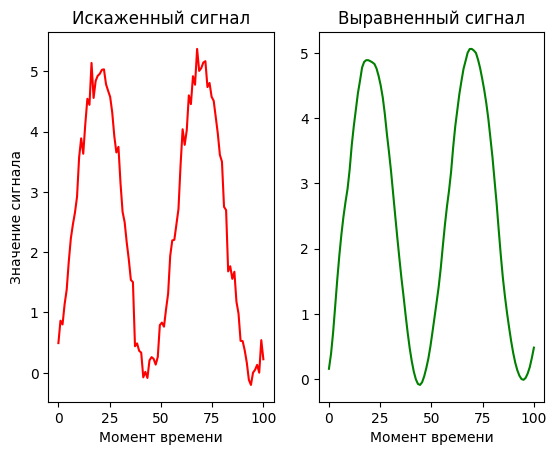

In [28]:
# Генерация нелинейного набора данных с шумом
x, y = DataPreparator().generate_nonlinear_dataset(1, 100, Noisemaker().add_perlin_noise)

# Изменение формы данных
x = x.reshape(-1, 100, 1)
y = y.flatten()

# Предсказание модели для выравнивания сигнала
eq = model.predict(x).flatten()

# Создание графика
lin_space = np.linspace(0, 100, 100)
fig, axs = plt.subplots(1, 2)

# Построение графика зашумленного сигнала на первом графике
axs[0].plot(lin_space, x.flatten(), color='r')
axs[0].set_title("Искаженный сигнал")
axs[0].set_xlabel("Момент времени")
axs[0].set_ylabel("Значение сигнала")

# Построение графика выравненного сигнала на втором графике
axs[1].plot(lin_space, eq.flatten(), color='g')
axs[1].set_title("Выравненный сигнал")
axs[1].set_xlabel("Момент времени")
plt.show()


# Задание

Реализуйте свою сеть для выравнивания нелинейного сигнала.

## Решение

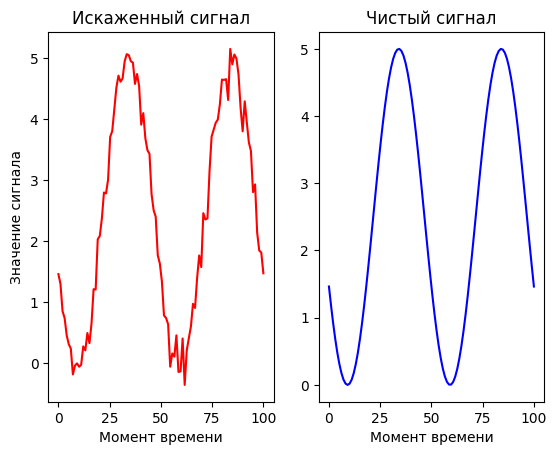

In [29]:
# Генерация обучающего набора данных: создание нелинейного набора данных с шумом
train_x, train_y = DataPreparator().generate_nonlinear_dataset(50, 100, Noisemaker().add_perlin_noise)
# Генерация валидационного набора данных: создание нелинейного набора данных с шумом
val_x, val_y = DataPreparator().generate_nonlinear_dataset(50, 100, Noisemaker().add_perlin_noise)
# Генерация тестового набора данных: создание нелинейного набора данных с шумом
test_x, test_y = DataPreparator().generate_nonlinear_dataset(50, 100, Noisemaker().add_perlin_noise)

# Индекс для вывода случайного сигнала с зашумлением и без
index = 45

# Создание графика
fig, axs = plt.subplots(1, 2)

# Построение графика зашумленного сигнала на первом графике
# Красный цвет для зашумленного сигнала
axs[0].plot(np.linspace(0, train_x[index].shape[0], train_x[index].shape[0]), train_x[index].flatten(), color='r')
axs[0].set_title("Искаженный сигнал")
axs[0].set_xlabel("Момент времени")
axs[0].set_ylabel("Значение сигнала")

# Синий цвет для чистого сигнала
axs[1].plot(np.linspace(0, train_y[index].shape[0], train_y[index].shape[0]), train_y[index].flatten(), color='b')
axs[1].set_title("Чистый сигнал")
axs[1].set_xlabel("Момент времени")
plt.show()

# Изменение формы обучающего набора данных
train_x = train_x.reshape(-1, 100, 1)
train_y = train_y.reshape(-1, 100, 1)

# Изменение формы валидационного набора данных
val_x = val_x.reshape(-1, 100, 1)
val_y = val_y.reshape(-1, 100, 1)

# Изменение формы тестового набора данных
test_x = test_x.reshape(-1, 100, 1)
test_y = test_y.reshape(-1, 100, 1)

In [39]:
# Создание LSTM-модели для шумоочистки сигнала
def create_noise_canceling_model(input_shape):
    model = models.Sequential([
        layers.LSTM(50, return_sequences=True, input_shape=input_shape),
        layers.TimeDistributed(layers.Dense(1)),
    ])
    return model

# Определение формы входных данных для модели
window_size = 100 # Определение размера окна
input_shape = (window_size, 1)

# Создание модели
model = create_noise_canceling_model(input_shape)

# Компиляция и обучение модели
model.compile(optimizer="adam", loss='mse')
print(model.summary())
model.fit(train_x,
          train_y,
          epochs=100,
          batch_size=32,
          callbacks=[TqdmCallback(verbose=1)],
          validation_data=(val_x, val_y),
          verbose=0)

# Сохранение обученной модели
model.save("hw_nn.h5")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 100, 50)           10400     
                                                                 
 time_distributed_3 (TimeDi  (None, 100, 1)            51        
 stributed)                                                      
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

1/1 [==============================] - 0s 413ms/step


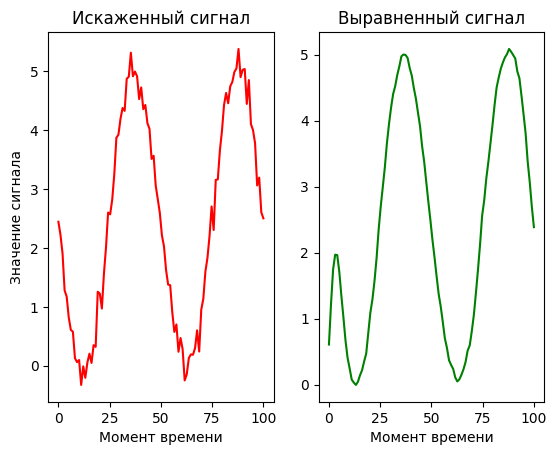

In [40]:
# Генерация нелинейного набора данных с шумом
x, y = DataPreparator().generate_nonlinear_dataset(1, 100, Noisemaker().add_perlin_noise)

# Изменение формы данных
x = x.reshape(-1, 100, 1)
y = y.flatten()

# Предсказание модели для выравнивания сигнала
eq = model.predict(x).flatten()

# Создание графика
lin_space = np.linspace(0, 100, 100)
fig, axs = plt.subplots(1, 2)

# Построение графика зашумленного сигнала на первом графике
axs[0].plot(lin_space, x.flatten(), color='r')
axs[0].set_title("Искаженный сигнал")
axs[0].set_xlabel("Момент времени")
axs[0].set_ylabel("Значение сигнала")

# Построение графика выравненного сигнала на втором графике
axs[1].plot(lin_space, eq.flatten(), color='g')
axs[1].set_title("Выравненный сигнал")
axs[1].set_xlabel("Момент времени")
plt.show()
